# Introduction

Ce projet a été réalisé par Baptiste Chezaubernard dans le cadre du cours de data mining par l'application.

Il suit le plan suivant :
1. Présentation du sujet
2. Lecture et préparation des données
3. Exploration des données
4. Modeling
5. Conclusion

# 1. Présentation du sujet

Le projet consiste à prévoir le nombre de vélos loués à chaque heure dans des bornes libres-services de la ville (système type Vélib'). La variable cible est ici la variable **count**.

Voici un descriptif de l'ensemble des variables :
* *datetime* - date et heure du relevé 
* *season* - 1 = printemps , 2 = été, 3 = automne, 4 = hiver 
* *holiday* – indique si le jour est un jour de vacances scolaires 
* *workingday* - indique si le jour est travaillé (ni week-end ni vacances) 
* *weather* - 1: Dégagé à nuageux, 2 : Brouillard, 3 : Légère pluie ou neige, 4 : Fortes averses ou neiges 
* *temp* – température en degrés Celsius 
* *atemp* – température ressentie en degrés Celsius 
* *humidity* – taux d’humidité 
* *windspeed* – vitesse du vent 
* *casual* - nombre de locations d’usagers non abonnés 
* *registered* – nombre de locations d’usagers abonnés 
* *count* – nombre total de locations de vélos 

L'objectif du projet est de mener à bien la création d'un modèle qui pourrait théoriquement être déployé en production. Les étapes d'exploration des données, de traitement et de preprocessing ne sont bien entendu pas à négliger. Il ne s'agit pas d'une compétition de type *Kaggle*, le projet ne sera pas uniquement noté sur la performance du modèle, mais plutôt sur votre approche complète et la justification de chacun de vos choix.

Comme vu durant le cours, soyez faites attention à certains points :
- quel type de problème dois-je traiter ?
- feature engineering : est-ce que j'utilise les données correctement, toutes les données ?
- data leakage : est-ce qu'une de mes features n'est pas trop explicative ?
- ai-je bien traité toutes les données correctement ?
- est-ce que mon modèle est adapté ?
- etc, etc, etc

Soyez vigilant à expliquer et justifier votre démarche à l'aide de visualisation, de commentaires dans vos codes (pensez aux cellules markdown), etc

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Lecture et préparation des données

##Lecture des données

Chargement du fichier velo.csv et affichage des données



In [2]:
url = "https://raw.githubusercontent.com/uazech/data-mining-velo/master/data/input/velo.csv"
df = pd.read_csv(url)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Affichage du nombre de modalités uniques par colonne. Permet de vérifier qu'il n'y a pas d'anomalies dans les données. 

In [3]:
df.nunique()

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
dtype: int64

Affichage du nombre de valeur manquante par colonne, afin de vérifier si on doit les traiter ou non.

Il n'y a pas de valeur manquante.

In [4]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Affichage des types de chaque feature. On remarque que : 
* La variable ```season``` est une variable catégorielle, et ne devrait pas être de type entier
* La variable ```datetime``` est considérée comme une variable catégorielle, à convertir en timeserie
* La variable ```weather``` est considérée comme une variable entière, alors qu'elle devrait être de type catégorielle

In [5]:
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Deux variables semblent suspectes. En effet, dans l'affichage du head précédent, la target était égale à la somme des deux variable registered et casual.

Dans la description des données, ces deux variables semblent également liées.

In [6]:

df[df["count"] == df["registered"] + df["casual"]].count() == df.count()

datetime      True
season        True
holiday       True
workingday    True
weather       True
temp          True
atemp         True
humidity      True
windspeed     True
casual        True
registered    True
count         True
dtype: bool

Les données sont effectivement liées. Les colonnes casual et registered seront à supprimer lors de la préparation des données. 
En effet, on ne connait pas le nombre de locations de vélo de type casual et registred lorsque l'on cherche à prédire le nombre de locations pour une journée.

## Préparation des données

Catégorisation des colonnes et changement des valeurs associées aux libellés

In [0]:
# Changement du type en série temporelle
df['datetime'] = pd.to_datetime(df['datetime'])  

# changement des types en catégoriels
df["season"] = df.season.map({1:"printemps", 2:"ete", 3:"automne", 4:"hiver"})
df["weather"] = df.weather.map({1:"degage_nuageux", 2:"brouillard", 3:"legere_pluie_neige", 4:"forte_averses_neige"})
df["season"] = pd.Categorical(df["season"], ordered=False)
df["weather"] = pd.Categorical(df["weather"], ordered=False)
df["holiday"] = pd.Categorical(df["holiday"], ordered=False)
df["workingday"] = pd.Categorical(df["workingday"], ordered=False)


Suppression des colonnes casual et registred

In [0]:
df = df.drop("casual", axis=1)
df = df.drop("registered", axis=1)

Définition de l'index du dataframe.

On choisit ici la colonne datetime, car les valeurs sont caractéristiques des données et qu'il n'y a pas de doublons.

In [9]:
df.set_index("datetime")

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
datetime,,,,,,,,,
2011-01-01 00:00:00,printemps,0,0,degage_nuageux,9.84,14.395,81,0.0000,16
2011-01-01 01:00:00,printemps,0,0,degage_nuageux,9.02,13.635,80,0.0000,40
2011-01-01 02:00:00,printemps,0,0,degage_nuageux,9.02,13.635,80,0.0000,32
2011-01-01 03:00:00,printemps,0,0,degage_nuageux,9.84,14.395,75,0.0000,13
2011-01-01 04:00:00,printemps,0,0,degage_nuageux,9.84,14.395,75,0.0000,1
...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,hiver,0,1,degage_nuageux,15.58,19.695,50,26.0027,336
2012-12-19 20:00:00,hiver,0,1,degage_nuageux,14.76,17.425,57,15.0013,241
2012-12-19 21:00:00,hiver,0,1,degage_nuageux,13.94,15.910,61,15.0013,168


Affichage des types et du dataframe

In [10]:
df.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                  int64
dtype: object

In [11]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,printemps,0,0,degage_nuageux,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,printemps,0,0,degage_nuageux,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,printemps,0,0,degage_nuageux,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,printemps,0,0,degage_nuageux,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,printemps,0,0,degage_nuageux,9.84,14.395,75,0.0,1


# 3. Exploration des données

## Analyse numérique

Il y a 10886 données. On peut, pour chaque donnée numérique regarder la moyenne, l'écart type et les quartiles.

In [12]:
df.describe()

,temp,atemp,humidity,windspeed,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,191.574132
std,7.79159,8.474601,19.245033,8.164537,181.144454
min,0.82000,0.760000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,42.000000
50%,20.50000,24.240000,62.000000,12.998000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,284.000000
max,41.00000,45.455000,100.000000,56.996900,977.000000


## Analyse univariée

### Variables numériques

Analyse de la répartition du nombre de location

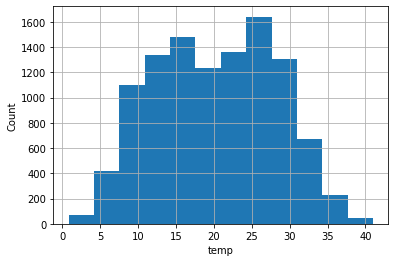

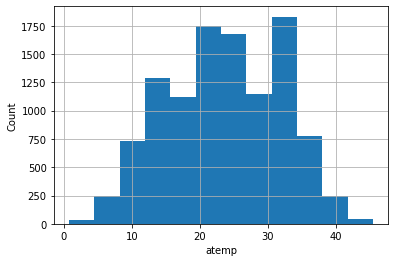

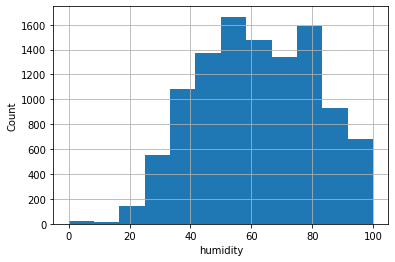

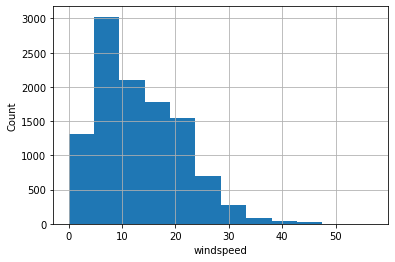

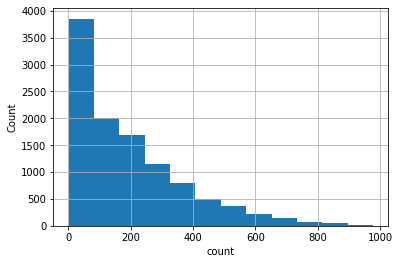

In [13]:
for colname, serie in df.iteritems():
  if serie.dtype.name in ['float64', 'int64']:
      serie.hist(bins=12)
      plt.title=" hist"
      plt.xlabel(colname)
      plt.ylabel("Count")
      plt.show()

On remarque que les variables temp, atemp et humidity semblent suivrent une distribution gaussienne.

La variable count semble suivre une loi exponentielle 

### Variables catégorielles

In [14]:
for colname, serie in df.iteritems():
    if serie.dtype.name in ['category']:
      print(df.groupby(colname)["datetime"].count(), "\n")

season
automne      2733
ete          2733
hiver        2734
printemps    2686
Name: datetime, dtype: int64 

holiday
0    10575
1      311
Name: datetime, dtype: int64 

workingday
0    3474
1    7412
Name: datetime, dtype: int64 

weather
brouillard             2834
degage_nuageux         7192
forte_averses_neige       1
legere_pluie_neige      859
Name: datetime, dtype: int64 



On remarque que les données sont relativement bien réparties.

Cependant, nous n'avons qu'une donnée pour la feature "weather" avec la modalité "forte_averses_neige".

J'ai fait le choix de la remplacer par la modalité "legere_pluie_neige", pour limiter le nombre de modalité.


In [0]:
df.weather.replace({"forte_averses_neige":"legere_pluie_neige"}, inplace=True)
df.groupby("weather")["datetime"].count()
df["weather"] = pd.Categorical(df["weather"], ordered=False)


### Série temporelle & feature enginering




Les dates sont des attributs particuliers. Nous allons réaliser du feature engineering afin d'en extraire des informations intéressantes.

Il y a 10886 valeurs uniques, comprises entre le 1er janvier 2011 à minuit et le 19 décembre 2012 à 23h.

In [16]:
df.datetime.describe()

count                   10886
unique                  10886
top       2011-06-09 04:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-19 23:00:00
Name: datetime, dtype: object

On réalise du feature engineering pour calculer :
* l'année
* le mois
* le jour de la semaine
* le jour
* l'heure
* le timestamp


In [0]:
# On garde l'année
df['year'] = pd.DatetimeIndex(df['datetime']).year
# On garde le mois de l'enregistrement
df['month'] = pd.DatetimeIndex(df['datetime']).month
# On garde le jour de l'enregistrement
df['day'] = pd.DatetimeIndex(df['datetime']).day
# On garde l'heure de l'enregistrement
df['hour'] = pd.DatetimeIndex(df['datetime']).hour
# On garde le jour de la semaine 
df['dayofweek'] = pd.DatetimeIndex(df['datetime']).dayofweek.map({0:"lundi", 1:"mardi", 2:"mercredi", 3:"jeudi", 4:"vendredi", 5:"samedi", 6:"dimanche"})

# On garde le timestamp pour une notion de continuité d'une année sur l'autre
df["timestamp"] = df.datetime.values.astype(np.int64) // 10 ** 9 

df["dayofweek"] = pd.Categorical(df["dayofweek"], ordered=True)
df["hour"] = pd.Categorical(df["hour"], ordered=True)
df["day"] = pd.Categorical(df["day"], ordered=True)
df["month"] = pd.Categorical(df["month"], ordered=True)
df["year"] = pd.Categorical(df["year"], ordered=True)



In [18]:
df.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                  int64
year                category
month               category
day                 category
hour                category
dayofweek           category
timestamp              int64
dtype: object

In [19]:
df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek,timestamp
10881,2012-12-19 19:00:00,hiver,0,1,degage_nuageux,15.58,19.695,50,26.0027,336,2012,12,19,19,mercredi,1355943600
10882,2012-12-19 20:00:00,hiver,0,1,degage_nuageux,14.76,17.425,57,15.0013,241,2012,12,19,20,mercredi,1355947200
10883,2012-12-19 21:00:00,hiver,0,1,degage_nuageux,13.94,15.910,61,15.0013,168,2012,12,19,21,mercredi,1355950800
10884,2012-12-19 22:00:00,hiver,0,1,degage_nuageux,13.94,17.425,61,6.0032,129,2012,12,19,22,mercredi,1355954400
10885,2012-12-19 23:00:00,hiver,0,1,degage_nuageux,13.12,16.665,66,8.9981,88,2012,12,19,23,mercredi,1355958000



## Analyse bivariée

### Analyse des jours fériés / jours travaillés

On remarque que le fait que le jour soit férié n'a pas une importance capitale. Cependant, les jours non fériés sont les jours durant lesquels il y a le plus de location.

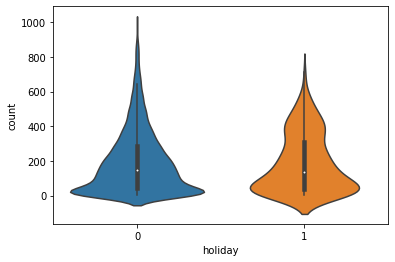

In [20]:
ax = sns.violinplot(x="holiday", y="count", data=df)

plt.show()

Etrangement le 1er janvier n'est pas considéré comme un jour ferié et le 17 novembre est un jour ferié. Il convidendrait de vérifier plus en détail la veracité des données pour cette feature

Après vérification deux jours fériés sont le 4 juillet 2011 et le 17 janvier, ce qui correspond respectivement à l'independance day et MLK day aux USA

In [21]:
df[df['holiday']==1].datetime.head()

372   2011-01-17 00:00:00
373   2011-01-17 01:00:00
374   2011-01-17 02:00:00
375   2011-01-17 03:00:00
376   2011-01-17 04:00:00
Name: datetime, dtype: datetime64[ns]

Le fait que le jour soit travaillé n'a pas de grande importance. On remarque cependant plus d'outliers sur les jours qui sont travaillés

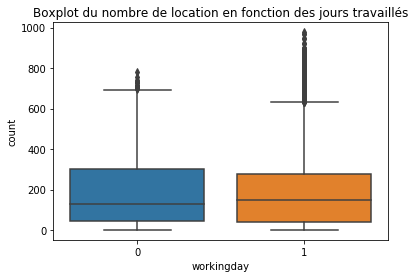

In [22]:
ax = sns.boxplot(x="workingday", y="count", data=df)
ax.set_title("Boxplot du nombre de location en fonction des jours travaillés")
plt.show()

Le jour de la semaine n'a pas d'importance significative sur la cible.

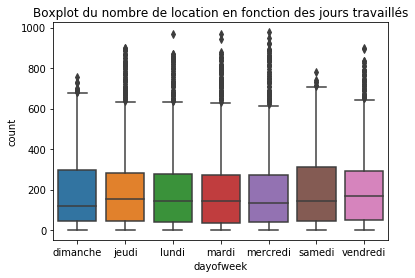

In [23]:
ax = sns.boxplot(x="dayofweek", y="count", data=df)
ax.set_title("Boxplot du nombre de location en fonction des jours travaillés")
plt.show()

### Analyse temporelle


On remarque que la saison a une grande importance sur le nombre de vélos loués.

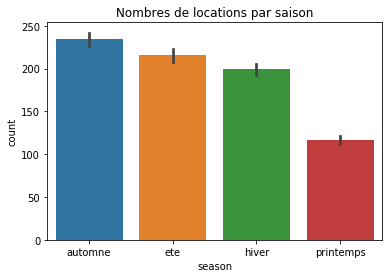

In [24]:
ax = sns.barplot(x="season", y="count", data=df)
ax.set_title("Nombres de locations par saison")
plt.show()

On remarque l'importance particulièrement élevé des mois sur les ventes.

Cette variable semble plus significative que la saison. Il conviendra peut-être de dropper la saison.

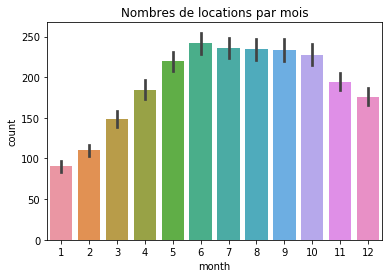

In [25]:
ax = sns.barplot(x="month", y="count", data=df)
ax.set_title("Nombres de locations par mois")
plt.show()

L'heure a une grande importance sur le nombre de locations

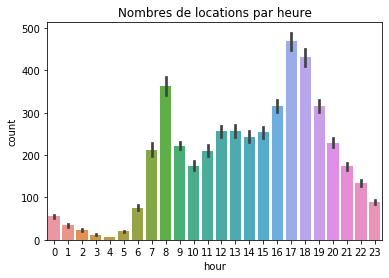

In [26]:
ax = sns.barplot(x="hour", y="count", data=df)
ax.set_title("Nombres de locations par heure")
plt.show()

Comme on pouvait le penser initalialement, le jour du mois n'est pas réélement significatif dans le nombre de vélos loués

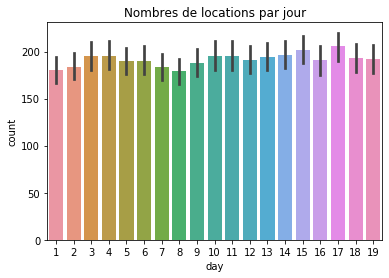

In [27]:
ax = sns.barplot(x="day", y="count", data=df)
ax.set_title("Nombres de locations par jour")
plt.show()

### Analyse de la météo

On remarque que les locations augmentent en moyenne avec la température.

Cependant, après un certain seuil de température, le nombre de location semble diminuer

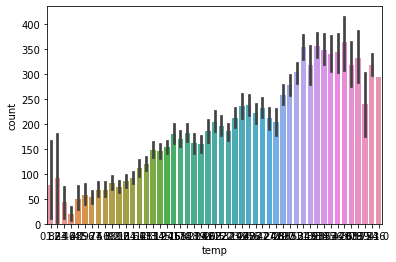

In [28]:
ax = sns.barplot(x="temp", y="count", data=df)

On remarque que l'humidité a une légère importance sur la cible

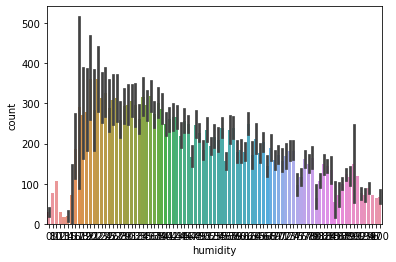

In [29]:
ax = sns.barplot(x="humidity", y="count", data=df)

La vitesse du vent n'a pas d'influence aussi décisive sur le nombre de locations. 

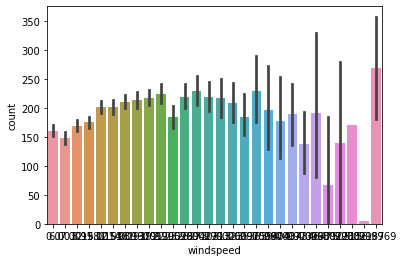

In [30]:
ax = sns.barplot(x="windspeed", y="count", data=df)

## Analyse multivariée

### Correlations

On remarque que la température réele et la température ressentie sont fortement corrélées.

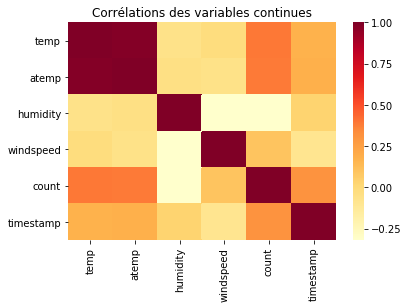

In [31]:
ax = sns.heatmap(df.corr(), cmap="YlOrRd")
ax.set_title("Corrélations des variables continues")
plt.show()

In [32]:
df.corr()

,temp,atemp,humidity,windspeed,count,timestamp
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.180986
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.181823
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,0.032856
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369,-0.086888
count,0.394454,0.389784,-0.317371,0.101369,1.000000,0.310187
timestamp,0.180986,0.181823,0.032856,-0.086888,0.310187,1.000000


Une corrélation de 98.5 entre les deux variables est trop importante. On supprimera donc une des deux colonnes.

Le choix se porte sur la température ressentie, qui est d'une certaine manière une fonction de la température rééele, du vent et de l'humidité.

In [0]:
df.drop("atemp",axis=1, inplace=True)

### Analyse multivariées


On remarque que la saisonalité est très similaire d'une année sur l'autre. 
Par contre, il semble qu'il y ai près de 2 fois plus de locations en 2012

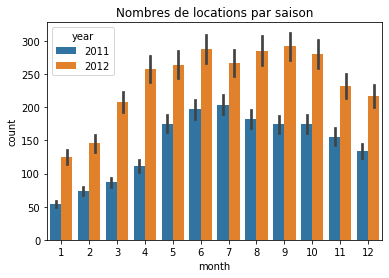

In [34]:
ax = sns.barplot(x="month", y="count", hue="year", data=df)
ax.set_title("Nombres de locations par saison")
plt.show()

La température et l'humidité ont une influence commune sur le nombre de locations. Globalement, plus il fait chaud, moins il fait humide et plus il y a de locations.

Après un certain seuil de température cepedant, le nombre de locations tend à diminuer.

Température, humidité et saison sont également très liés. Il est interessant de noter qu'il fait plus chaud en hiver qu'au printemps et plus froid en été qu'en automne.  

[]

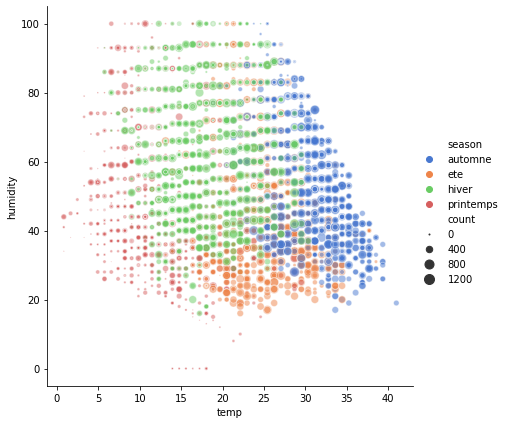

In [35]:
sns.relplot(x="temp", y="humidity", hue="season", size="count",
            sizes=(1, 100), alpha=.5, palette="muted",
            height=6, data=df)
plt.plot()

# 4. Modeling 

## Preprocessing

### Ajustement des variables

J'ai choisi de dropper la saison, car je la trouvais non significative en raison de la présence du mois. En effet, les dates de notre dataset allant de 1 à 19, la saison n'apporte pas plus d'information que le mois.

J'ai également décidé de dropper la variable jour, qui n'apporte pas d'information spécifique

In [0]:
df = df.drop("season", axis=1)
df = df.drop("day", axis=1)

In [37]:
df.dtypes

datetime      datetime64[ns]
holiday             category
workingday          category
weather             category
temp                 float64
humidity               int64
windspeed            float64
count                  int64
year                category
month               category
hour                category
dayofweek           category
timestamp              int64
dtype: object

Analyse du nombre de modalité des variables catégorielles. 

Le nombre n'étant pas trop élévé, on pourra one-hot-encoder les variables.

In [38]:
categorical_features = df.columns[df.dtypes == "category"].tolist()
print(df[categorical_features].nunique())

holiday        2
workingday     2
weather        3
year           2
month         12
hour          24
dayofweek      7
dtype: int64


### Dummification / One hot encoding

On dummifie de manière à obtenir un dataset

In [39]:
df_dummies = pd.get_dummies(df[categorical_features], drop_first=True)
# on concatène ensuite avec le dataset original
df_final = pd.concat([df.drop(categorical_features, axis=1), df_dummies], axis=1)
print(df_final.shape)
print(df_final.dtypes)

(10886, 51)
datetime                      datetime64[ns]
temp                                 float64
humidity                               int64
windspeed                            float64
count                                  int64
timestamp                              int64
holiday_1                              uint8
workingday_1                           uint8
weather_degage_nuageux                 uint8
weather_legere_pluie_neige             uint8
year_2012                              uint8
month_2                                uint8
month_3                                uint8
month_4                                uint8
month_5                                uint8
month_6                                uint8
month_7                                uint8
month_8                                uint8
month_9                                uint8
month_10                               uint8
month_11                               uint8
month_12                               uint

### Séparation

In [40]:
y = df_final.pop('count')
X = df_final.drop("datetime", axis=1)
X.head()

,temp,humidity,windspeed,timestamp,holiday_1,workingday_1,weather_degage_nuageux,weather_legere_pluie_neige,year_2012,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayofweek_jeudi,dayofweek_lundi,dayofweek_mardi,dayofweek_mercredi,dayofweek_samedi,dayofweek_vendredi
0,9.84,81,0.0,1293840000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,9.02,80,0.0,1293843600,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,9.02,80,0.0,1293847200,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,9.84,75,0.0,1293850800,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,9.84,75,0.0,1293854400,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [41]:
y.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

On vérifie qu'il n'y a pas de valeur manquantes

In [42]:
print(X.isna().sum().sum() == 0)

True


Séparation train / test

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
print(f"X train shape  {X_train.shape}")
print(f"y train shape  {y_train.shape}")
print(f"X test shape  {X_test.shape}")
print(f"y test shape  {y_test.shape}")

X train shape  (8708, 49)
y train shape  (8708,)
X test shape  (2178, 49)
y test shape  (2178,)


### Standardisation
J'ai retiré la standardisation du prétraitement des données car elle rendait les paramètres de la régression linéaire incompréhensible

In [0]:
# from sklearn.preprocessing import StandardScaler
# imp = StandardScaler()

# X_train = imp.fit_transform(X_train)
# X_test = imp.transform(X_test)


## Regression linéaire


### Construction du modèle

In [0]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression(normalize=False)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
y_predtrain = regr.predict(X_train)

### Analyse des résultats
La Mean Squared Error sur le jeu de test est de 10442, ce qui donne une erreur moyenne de 100 pour chaque prédiction.
Le coefficient de determination r2 dont la valeur vaut 0.7 indique que le modèle ne colle pas très bien aux données

In [45]:
print(f"Mean squared error on test : {mean_squared_error(y_test, y_pred)}")
print(f"Mean squared error on train: {mean_squared_error(y_train, y_predtrain)}")
print('r2_score score: %.2f on test' % r2_score(y_test, y_pred))
print('r2_score score: %.2f on train' % r2_score(y_train, y_predtrain))

Mean squared error on test : 10442.573152089572
Mean squared error on train: 9929.658814499955
r2_score score: 0.69 on test
r2_score score: 0.70 on train


### Analyse des  coefficients de la regression linéaire

Les coefficients de la régression linéaire donne du sens au modèle : 
* temp=5 : plus la température augmente, plus il y a de location
* humidity=-0.78 : plus l'humidité augmente, moins il y a de locations.
* Les coefficient des heures collent avec les données visualisées précédement

In [46]:
for index, col in enumerate(X):
  print(index, col, regr.coef_[index])

0 temp 5.039459308593245
1 humidity -0.7838253896020376
2 windspeed -0.6246655814836574
3 timestamp 4.46008372810801e-06
4 holiday_1 4.262949808131022
5 workingday_1 7.266992860509763
6 weather_degage_nuageux 10.885765212646376
7 weather_legere_pluie_neige -54.95501315707943
8 year_2012 -53.00774662468775
9 month_2 2.5628939499183914
10 month_3 11.480991876426879
11 month_4 22.886160998605078
12 month_5 36.88901932854951
13 month_6 14.132626638314258
14 month_7 -29.078617250117993
15 month_8 -29.249271267772585
16 month_9 -17.59255940147708
17 month_10 -3.6141178741065945
18 month_11 -35.82703587589588
19 month_12 -46.923406103279
20 hour_1 -17.683906765928228
21 hour_2 -30.813544125305633
22 hour_3 -38.717183048157544
23 hour_4 -40.84018508116969
24 hour_5 -25.85785823211406
25 hour_6 37.08015096971303
26 hour_7 169.0408072523036
27 hour_8 311.5502313432751
28 hour_9 164.92100575123965
29 hour_10 110.73160269678691
30 hour_11 133.6836929425176
31 hour_12 178.76725106172984
32 hour_13 

Il semble qu'au vu des résultats, la régression linéaire ne soit pas adaptée (L'erreur moyenne est très importante). Ce modèle fournit cependant des indicateurs concernant l'impact des différentes features dans la prédiction. 

La régression ne permet pas de prendre en compte des événéments qui varient de manière cyclique au cours du temps.

## Arbre de décision

J'ai choisi une profondeur maximimum de 30. En effet, au delà, le modèle a tendance à sur-apprendre, mais les résultats sur le jeu de test ne changent pas. 

In [47]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=30)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
trainPredictions = tree.predict(X_train)


print(f"R2 score : {r2_score(predictions,y_test)}")
print(f"Mean squared error on test: {mean_squared_error(predictions, y_test)}")
print(f"Mean squared error on train: {mean_squared_error(trainPredictions, y_train)}")

R2 score : 0.8490057118285289
Mean squared error on test: 5137.656054508506
Mean squared error on train: 62.22124694592554


Ce modèle est plus performant que la régression linéaire. Cependant, avec un arbre d'une profondeur de 30, le modèle obtenu est difficile à expliquer. 

On peut regarder l'importance des features au sein du modèle, comme présenté ci-dessous.


In [48]:
for index, col in enumerate(X):
  print(index, col, tree.feature_importances_[index])

0 temp 0.09869755449168555
1 humidity 0.09275028870170006
2 windspeed 0.012305124430273134
3 timestamp 0.16779082481145394
4 holiday_1 0.00030233993634010484
5 workingday_1 0.09615523475306266
6 weather_degage_nuageux 0.00198011629769582
7 weather_legere_pluie_neige 0.0070446315317273306
8 year_2012 3.796546088910202e-05
9 month_2 0.0004974789102296113
10 month_3 0.00023910708885609564
11 month_4 0.0006743398985735229
12 month_5 0.0007586508314055395
13 month_6 0.0018077694365998878
14 month_7 0.001971905924620013
15 month_8 0.0012403023143819371
16 month_9 0.0006370536016552508
17 month_10 0.0022894335776287283
18 month_11 0.00031323201625375023
19 month_12 0.0002316796370308792
20 hour_1 0.020664882031218863
21 hour_2 0.021047119305545127
22 hour_3 0.018261744473214568
23 hour_4 0.019084758346309807
24 hour_5 0.018425603497487043
25 hour_6 0.010079319975385774
26 hour_7 0.013405267631816445
27 hour_8 0.06595918468796776
28 hour_9 0.009711381992533644
29 hour_10 0.004666842185823687
3

On remarque que le timestamp a une importance significative sur le model. Les autres features, à l'exception de l'année n'apportent que peu d'information.

## XGBoost

In [49]:
import xgboost

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)
predictions = xgb.predict(X_test)
print(f"R2 score : {r2_score(predictions,y_test)}")
print(f"Mean squared error on test: {mean_squared_error(predictions, y_test)}")

[23:50:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


R2 score : 0.9110164604522909
Mean squared error on test: 2577.0178017265594


Au vu des résultats obtenus, ce modèle est performant. Il garanti une erreur raisonablement faible et permet d'avoir un score élévé (0.91).

On peut à nouveau regarder l'importance de chaque feature sur le modèle

In [50]:
for index, col in enumerate(X):
  print(index, col, xgb.feature_importances_[index])

0 temp 0.009173659
1 humidity 0.011748621
2 windspeed 0.0009144888
3 timestamp 0.010875616
4 holiday_1 0.002051543
5 workingday_1 0.019936474
6 weather_degage_nuageux 0.00097021123
7 weather_legere_pluie_neige 0.0039968207
8 year_2012 0.0
9 month_2 0.0003727286
10 month_3 0.00048172547
11 month_4 0.0012504327
12 month_5 0.001981463
13 month_6 0.0008480525
14 month_7 0.0062100375
15 month_8 0.001167072
16 month_9 0.00090489106
17 month_10 0.0019550517
18 month_11 0.00077642617
19 month_12 0.0019785755
20 hour_1 0.06816016
21 hour_2 0.06469462
22 hour_3 0.079383396
23 hour_4 0.08348291
24 hour_5 0.06660425
25 hour_6 0.029727181
26 hour_7 0.024353534
27 hour_8 0.07194971
28 hour_9 0.01628077
29 hour_10 0.005179769
30 hour_11 0.011259262
31 hour_12 0.021443924
32 hour_13 0.018439582
33 hour_14 0.013900194
34 hour_15 0.012185737
35 hour_16 0.03529095
36 hour_17 0.097971424
37 hour_18 0.08782672
38 hour_19 0.045240115
39 hour_20 0.014352749
40 hour_21 0.004938695
41 hour_22 0.0077463295
42 h

Ce modèle prend en compte les features de manière plus équilibrée que l'arbre de régression.

# 5. Conclusion

Ce projet m'aura permis de me familiariser avec les librairies ```sklearn``` et ```seaborn```.

J'ai pu réaliser une exploration de données, et tester différents modèles permettant d'effectuer des prédictions.